In [1]:
import os
import sys
from collections import defaultdict, Counter
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from Bio import SeqIO

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp
from pymutspec.constants import possible_sbs192

In [2]:
mus_cytb = dict()
mus_nd1 = dict()
human_cytb = dict()
human_nd1 = dict()

In [3]:
mus_cytb["aln"] = [str(x.seq) for x in SeqIO.parse("../data/exposure/mus_cytb/alignment_checked.fasta", format="fasta")]
mus_nd1["aln"] = [str(x.seq) for x in SeqIO.parse("../data/exposure/mus_nd1/alignment_checked.fasta", format="fasta")]
human_cytb["aln"] = [str(x.seq) for x in SeqIO.parse("../data/exposure/human_cytb/alignment_checked.fasta", format="fasta")]
human_nd1["aln"] = [str(x.seq) for x in SeqIO.parse("../data/exposure/human_nd1/alignment_checked.fasta", format="fasta")]

In [4]:
mus_cytb["aln_2mln"] = [str(x.seq) for x in SeqIO.parse("../data/MUS/mulal/CYTB.fna", format="fasta")]
mus_nd1["aln_2mln"] = [str(x.seq) for x in SeqIO.parse("../data/MUS/mulal/ND1.fna", format="fasta")]
human_cytb["aln_2mln"] = [str(x.seq) for x in SeqIO.parse("../data/GAGP/mulal/CYTB.fna", format="fasta")]
human_nd1["aln_2mln"] = [str(x.seq) for x in SeqIO.parse("../data/GAGP/mulal/ND1.fna", format="fasta")]

In [5]:
human_cytb["rate"] = pd.read_csv("../data/exposure/human_cytb/CYTB.rate", sep="\t", comment="#")
human_nd1["rate"] = pd.read_csv("../data/exposure/human_nd1/ND1.rate", sep="\t", comment="#")
mus_cytb["rate"] = pd.read_csv("../data/exposure/mus_cytb/CYTB.rate", sep="\t", comment="#")
mus_nd1["rate"] = pd.read_csv("../data/exposure/mus_nd1/ND1.rate", sep="\t", comment="#")

In [6]:
def get_variability_rate(aln):
    seq = []
    n = len(aln)
    for column in zip(*aln):
        m = Counter(column).most_common()[0][1]
        seq.append(m / n)
    return seq

In [7]:
## Check 0 category of rates (it must be invariant)
for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    cats = data['rate']['Cat'].values
    vrate = get_variability_rate(data['aln'])
    print(lbl)
    assert len(cats) == len(vrate)
    for site,(c, vr) in enumerate(zip(cats, vrate), 1):
        if c == 0 and vr != 1 or c != 0 and vr == 1:
            print(f"cat = {c}, vrate = {vr:.2f} on site {site}")
    
    print()

human_cytb
cat = 5, vrate = 1.00 on site 4
cat = 5, vrate = 1.00 on site 7
cat = 5, vrate = 1.00 on site 9
cat = 5, vrate = 1.00 on site 11
cat = 5, vrate = 1.00 on site 15
cat = 0, vrate = 0.99 on site 18
cat = 5, vrate = 1.00 on site 24
cat = 5, vrate = 1.00 on site 27
cat = 5, vrate = 1.00 on site 30
cat = 5, vrate = 1.00 on site 31
cat = 5, vrate = 1.00 on site 32
cat = 5, vrate = 1.00 on site 42
cat = 5, vrate = 1.00 on site 45
cat = 5, vrate = 1.00 on site 46
cat = 5, vrate = 1.00 on site 47
cat = 5, vrate = 1.00 on site 52
cat = 5, vrate = 1.00 on site 54
cat = 5, vrate = 1.00 on site 55
cat = 5, vrate = 1.00 on site 57
cat = 5, vrate = 1.00 on site 63
cat = 5, vrate = 1.00 on site 66
cat = 5, vrate = 1.00 on site 72
cat = 5, vrate = 1.00 on site 75
cat = 5, vrate = 1.00 on site 78
cat = 5, vrate = 1.00 on site 81
cat = 5, vrate = 1.00 on site 84
cat = 5, vrate = 1.00 on site 85
cat = 5, vrate = 1.00 on site 90
cat = 5, vrate = 1.00 on site 105
cat = 5, vrate = 1.00 on site 108


In [8]:
def get_consensus(aln):
    seq = []
    for column in zip(*aln):
        nuc = Counter(column).most_common()[0][0]
        seq.append(nuc)
    return "".join(seq)

In [9]:
human_cytb["consensus"] = get_consensus(human_cytb["aln"])
human_nd1["consensus"] = get_consensus(human_nd1["aln"])
mus_cytb["consensus"] = get_consensus(mus_cytb["aln"])
mus_nd1["consensus"] = get_consensus(mus_nd1["aln"])

In [10]:
human_cytb["consensus"]

'ATGACCCCAATACGCAAAACTAACCCCCTAATAAAATTAATTAACCACTCATTCATCGACCTCCCCACCCCATCCAACATCTCCGCATGATGAAACTTCGGCTCACTCCTTGGCGCCTGCCTGATCCTCCAAATCACCACAGGACTATTCCTAGCCATGCACTACTCACCAGACGCCTCAACCGCCTTTTCATCAATCGCCCACATCACTCGAGACGTAAATTATGGCTGAATCATCCGCTACCTTCACGCCAATGGCGCCTCAATATTCTTTATCTGCCTCTTCCTACACATCGGGCGAGGCCTATATTACGGATCATTTCTCTACTCAGAAACCTGAAACATCGGCATTATCCTCCTGCTTGCAACTATAGCAACAGCCTTCATAGGCTATGTCCTCCCGTGAGGCCAAATATCATTCTGAGGGGCCACAGTAATTACAAACTTACTATCCGCCATCCCATACATTGGGACAGACCTAGTTCAATGAATCTGAGGAGGCTACTCAGTAGACAGTCCCACCCTCACACGATTCTTTACCTTTCACTTCATCTTGCCCTTCATTATTGCAGCCCTAGCAGCACTCCACCTCCTATTCTTGCACGAAACGGGATCAAACAACCCCCTAGGAATCACCTCCCATTCCGATAAAATCACCTTCCACCCTTACTACACAATCAAAGACGCCCTCGGCTTACTTCTCTTCCTTCTCTCCTTAATGACATTAACACTATTCTCACCAGACCTCCTAGGCGACCCAGACAATTATACCCTAGCCAACCCCTTAAACACCCCTCCCCACATCAAGCCCGAATGATATTTCCTATTCGCCTACACAATTCTCCGATCCGTCCCTAACAAACTAGGAGGCGTCCTTGCCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAACAAAGCATAATATTTCGCCCACTAAGCCAATCACTTTATTGACTCCTAGCCGCAGACCTCCTC

In [11]:
len(human_cytb["consensus"])

1137

In [12]:
human_cytb["ms_obs192"] = pd.read_csv("../data/exposure/human_cytb/ms/ms192syn_human_cytb.tsv", sep="\t")
human_nd1["ms_obs192"] = pd.read_csv("../data/exposure/human_nd1/ms/ms192syn_human_nd1.tsv", sep="\t")
mus_cytb["ms_obs192"] = pd.read_csv("../data/exposure/mus_cytb/ms/ms192syn_mus_cytb.tsv", sep="\t")
mus_nd1["ms_obs192"] = pd.read_csv("../data/exposure/mus_nd1/ms/ms192syn_mus_nd1.tsv", sep="\t")

human_cytb["ms_obs12"] = pd.read_csv("../data/exposure/human_cytb/ms/ms12syn_human_cytb.tsv", sep="\t")

In [13]:
human_cytb["ms_exp192"] = pd.read_csv("../data/exposure/human_cytb/pyvolve/out/ms192syn_human_cytb_simulated.tsv", sep="\t")
human_nd1["ms_exp192"] = pd.read_csv("../data/exposure/human_nd1/pyvolve/out/ms192syn_human_nd1_simulated.tsv", sep="\t")
mus_cytb["ms_exp192"] = pd.read_csv("../data/exposure/mus_cytb/pyvolve/out/ms192syn_mus_cytb_simulated.tsv", sep="\t")
mus_nd1["ms_exp192"] = pd.read_csv("../data/exposure/mus_nd1/pyvolve/out/ms192syn_mus_nd1_simulated.tsv", sep="\t")

In [14]:
human_cytb["mutations"] = pd.read_csv("../data/exposure/human_cytb/observed_mutations_iqtree.tsv", sep="\t").sort_values("PosInGene")
human_nd1["mutations"] = pd.read_csv("../data/exposure/human_nd1/observed_mutations_iqtree.tsv", sep="\t").sort_values("PosInGene")
mus_cytb["mutations"] = pd.read_csv("../data/exposure/mus_cytb/observed_mutations_iqtree.tsv", sep="\t").sort_values("PosInGene")
mus_nd1["mutations"] = pd.read_csv("../data/exposure/mus_nd1/observed_mutations_iqtree.tsv", sep="\t").sort_values("PosInGene")

In [15]:
import warnings
warnings.filterwarnings("ignore")

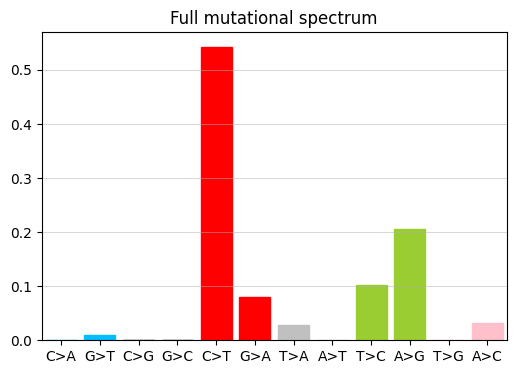

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


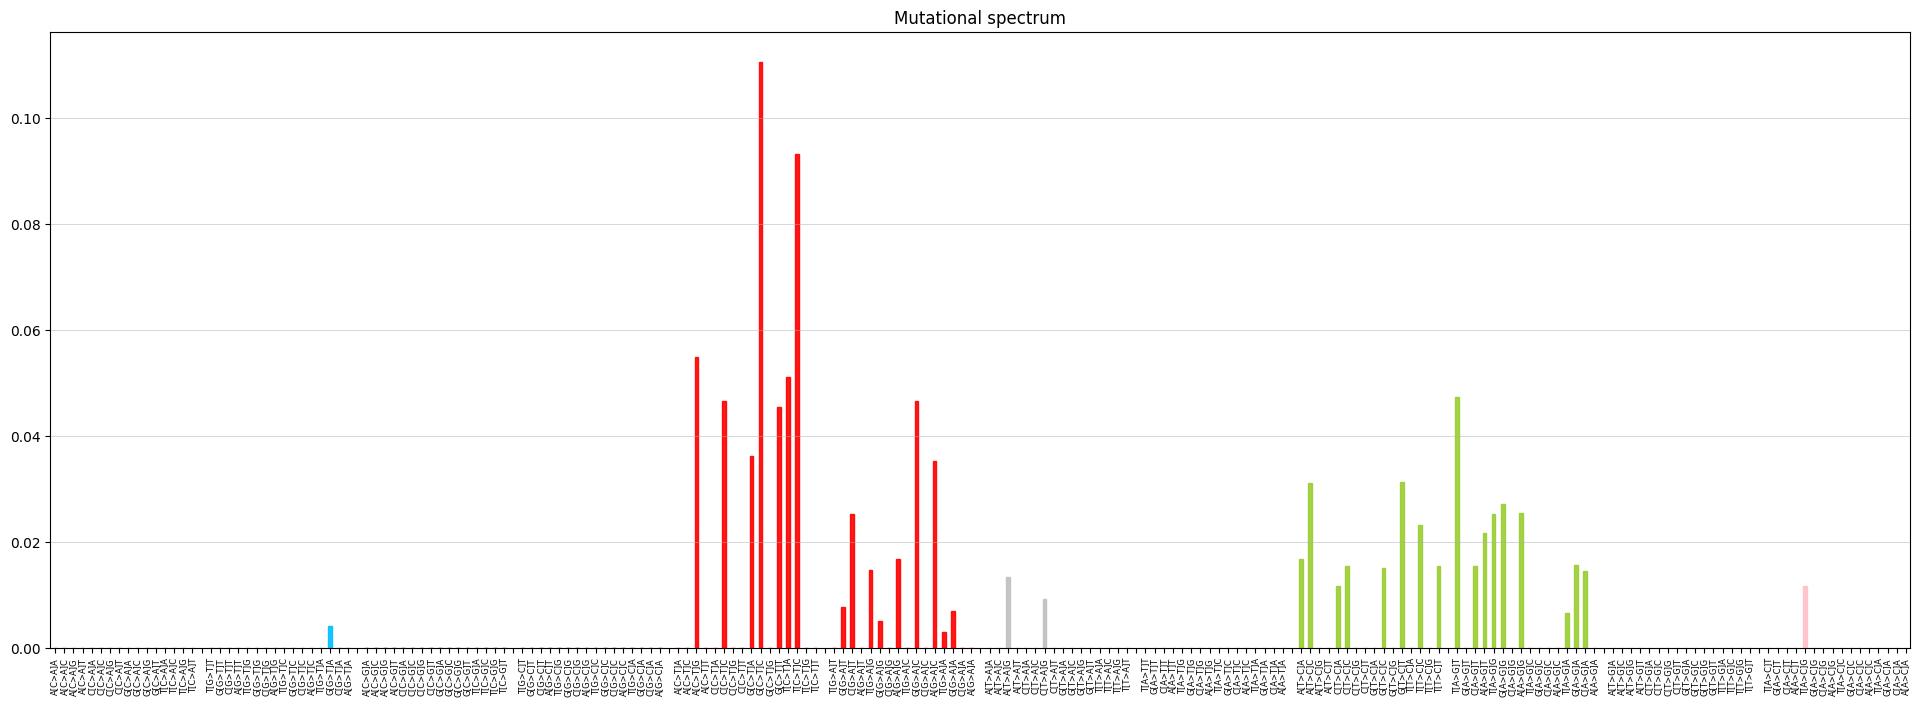

In [16]:
plot_mutspec12(human_cytb["ms_obs12"])
plot_mutspec192(human_cytb["ms_obs192"])

In [39]:
def count_diff(df):
    nzeros = (df.ObsNum_sim == 0).sum()
    nplus = ((df.ObsNum_rec.round() > df.ObsNum_sim) & (df.ObsNum_sim != 0)).sum()
    nminus = ((df.ObsNum_rec.round() < df.ObsNum_sim) & (df.ObsNum_sim != 0)).sum()
    n = nzeros + nplus + nminus
    n_eq = 200 - n
    return pd.Series(dict(nzeros=nzeros, n_eq=n_eq,nplus=nplus, nminus=nminus, zerosFr=nzeros/n, plusFr=nplus/n, minusFr=nminus/n))


def get_significance(df):
    a = df.nplus.item()
    b = df.nminus.item()
    n = a + b
    if n > 5:
        pval = binom_test(a, n)
    else:
        pval = np.nan
    return pval

### Mouse

In [79]:
for data in [mus_cytb, mus_nd1]:
    # drop low-proba mutations from ObsNum (simple replace)
    pcutoff = 0.3
    _ms_obs192 = data["ms_obs192"].copy()
    high_proba_muts_syn = data["mutations"][
        (data["mutations"].ProbaFull > pcutoff) & 
        (data["mutations"].Label > 0) &
        (data["mutations"].AltNode.str.startswith("Node"))
    ]
    high_proba_muts_syn["Mut"] = high_proba_muts_syn["Mut"].apply(rev_comp)
    high_proba_obs = high_proba_muts_syn.groupby("Mut").ProbaFull.sum().to_dict()
    _ms_obs192["ObsNum"] = _ms_obs192["Mut"].map(high_proba_obs).fillna(0.)
    

    # merge rec and sim
    df = _ms_obs192.merge(data["ms_exp192"], on="Mut", suffixes=["_rec", "_sim"])
    df["diff"] = df["ObsNum_rec"] - df["ObsNum_sim"]
    data["both"] = df
    gr = df.groupby("Mut")
    
    diff_stats = gr.agg({"ObsNum_rec": "mean", "ObsNum_sim": "mean"})

    # diff_stats = gr["diff"].agg(
    #     ["mean", "std", lambda x: bootstrap((x,), np.mean).confidence_interval])
    # diff_stats["low"] = diff_stats["<lambda_0>"].apply(lambda x: x.low)
    # diff_stats["high"] = diff_stats["<lambda_0>"].apply(lambda x: x.high)
    # diff_stats.drop("<lambda_0>", axis=1, inplace=True)
    
    _diff_stats2 = gr.apply(count_diff)
    diff_stats = diff_stats.merge(_diff_stats2, left_index=True, right_index=True)
    del _diff_stats2
    diff_stats["p-value"] = diff_stats["n_eq"] / 201
    # diff_stats["p-value"] = diff_stats.apply(get_significance, axis=1)
    diff_stats["p-value-adj"] = multipletests(diff_stats["p-value"], method="bonferroni")[1]

    data["diff_stats"] = diff_stats

    # place mutations on consensus
    # data["muts_positive"] = diff_stats[(diff_stats['low']  >  1e-2) & (diff_stats["std"] > 0)].index.values
    # data["muts_negative"] = diff_stats[(diff_stats['high'] < -1e-2) & (diff_stats["std"] > 0)].index.values
    data["muts_positive"] = diff_stats[(diff_stats["nplus"] > diff_stats["nminus"]) & (diff_stats["p-value-adj"] < 0.05)  & (diff_stats["ObsNum_rec"] > 0)].index.values
    data["muts_negative"] = diff_stats[(diff_stats["nplus"] < diff_stats["nminus"]) & (diff_stats["p-value-adj"] < 0.05)  & (diff_stats["ObsNum_rec"] > 0)].index.values

    # need to rev-comp mutations, because used spectra for heavy strand (see images above)
    data["muts_positive"] = [rev_comp(x) for x in data["muts_positive"]]
    data["muts_negative"] = [rev_comp(x) for x in data["muts_negative"]]

    # break


### Human

In [115]:
for data in [human_cytb, human_nd1]:
    _ms_obs192 = data["ms_obs192"].copy()

    # merge rec and sim
    df = _ms_obs192.merge(data["ms_exp192"], on="Mut", suffixes=["_rec", "_sim"])
    df["diff"] = df["ObsNum_rec"] - df["ObsNum_sim"]
    data["both"] = df
    gr = df.groupby("Mut")

    diff_stats = gr.agg({"ObsNum_rec": "mean", "ObsNum_sim": "mean"})

    _diff_stats2 = gr.apply(count_diff)
    diff_stats = diff_stats.merge(_diff_stats2, left_index=True, right_index=True)
    del _diff_stats2
    diff_stats["p-value"] = diff_stats["n_eq"] / 201
    diff_stats["p-value-adj"] = multipletests(diff_stats["p-value"])[1]

    data["diff_stats"] = diff_stats

    # place mutations on consensus
    data["muts_positive"] = diff_stats[(diff_stats["nplus"] > diff_stats["nminus"]) & (diff_stats["ObsNum_rec"] > 0) & (diff_stats["p-value"] < 0.01) & (diff_stats["zerosFr"] < 0.95)].index.values
    data["muts_negative"] = diff_stats[(diff_stats["nplus"] < diff_stats["nminus"]) & (diff_stats["ObsNum_rec"] > 0) & (diff_stats["p-value"] < 0.01) & (diff_stats["zerosFr"] < 0.95)].index.values

    # need to rev-comp mutations, because used spectra for heavy strand (see images above)
    # data["muts_positive"] = [rev_comp(x) for x in data["muts_positive"]]
    # data["muts_negative"] = [rev_comp(x) for x in data["muts_negative"]]

    # break


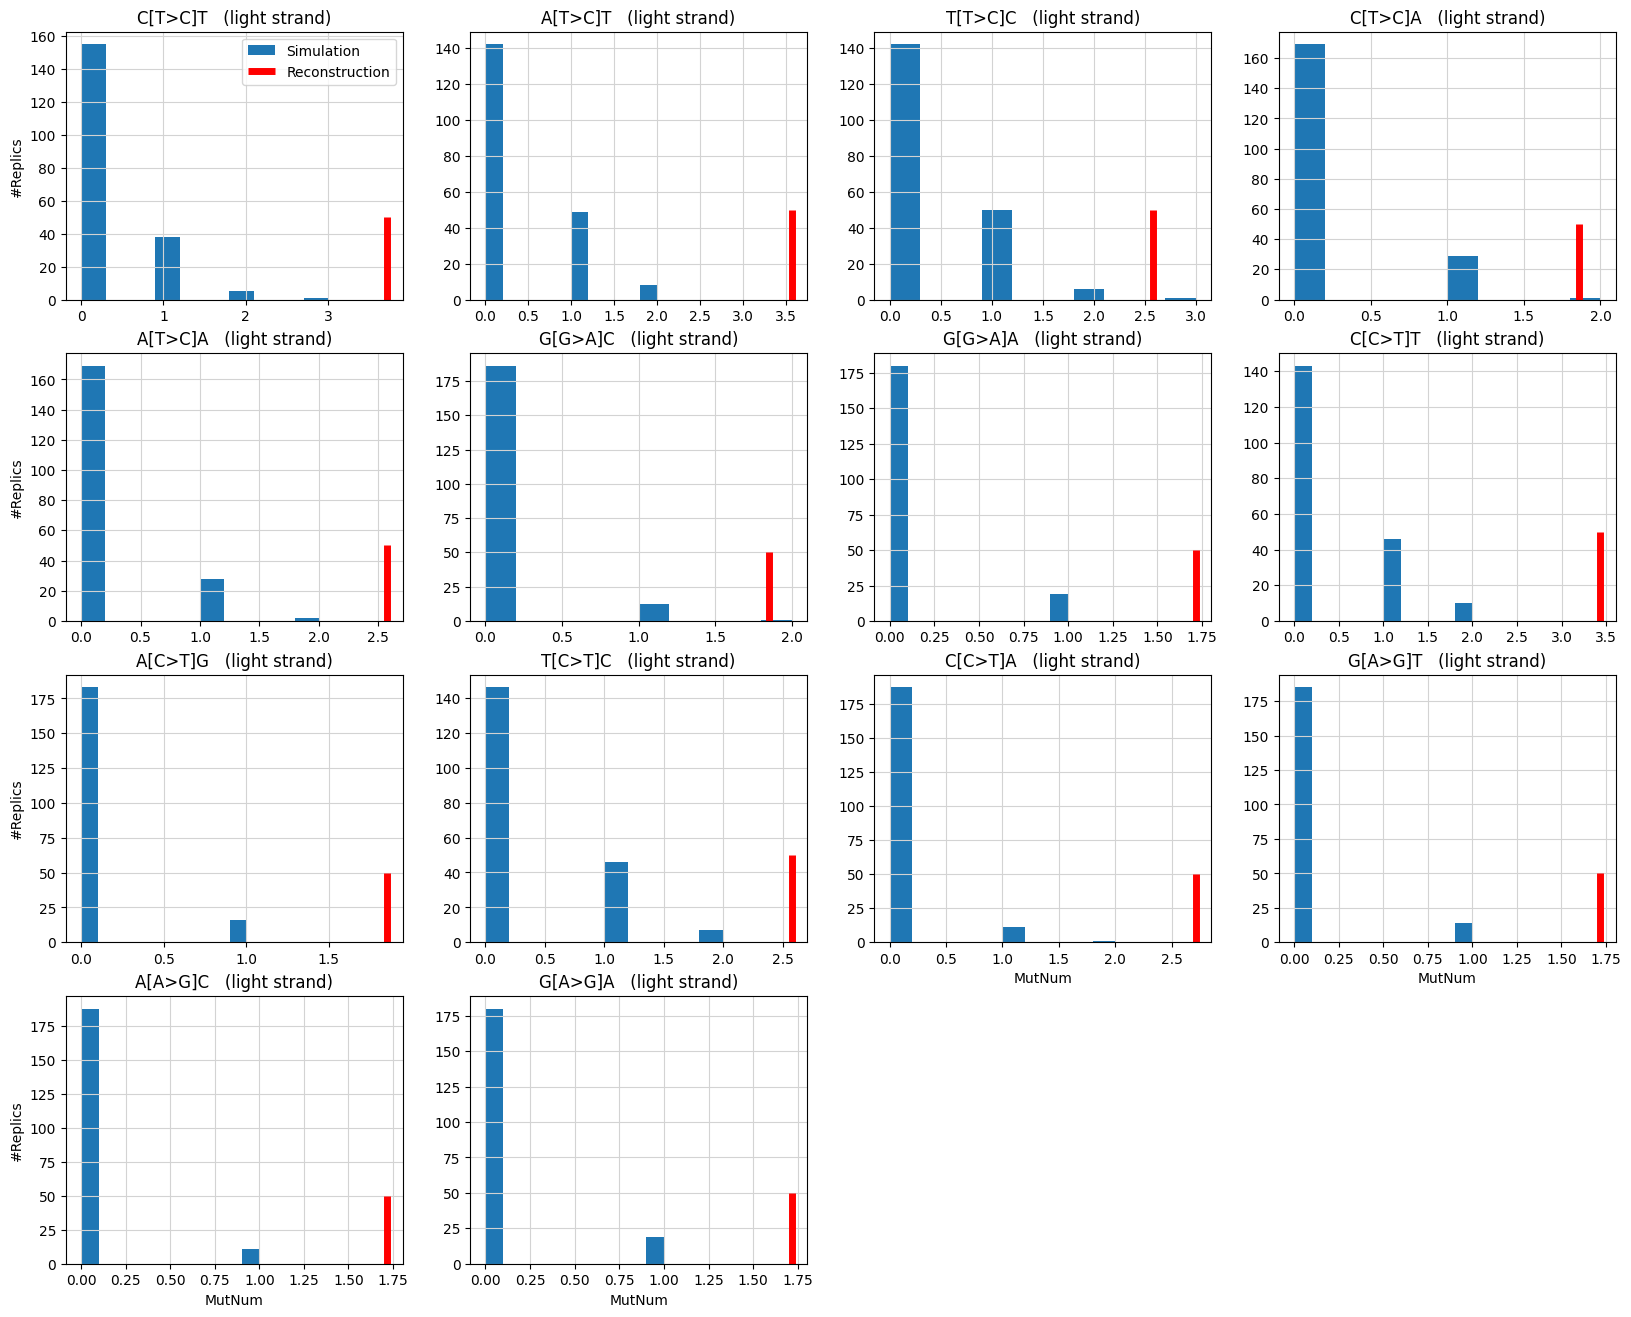

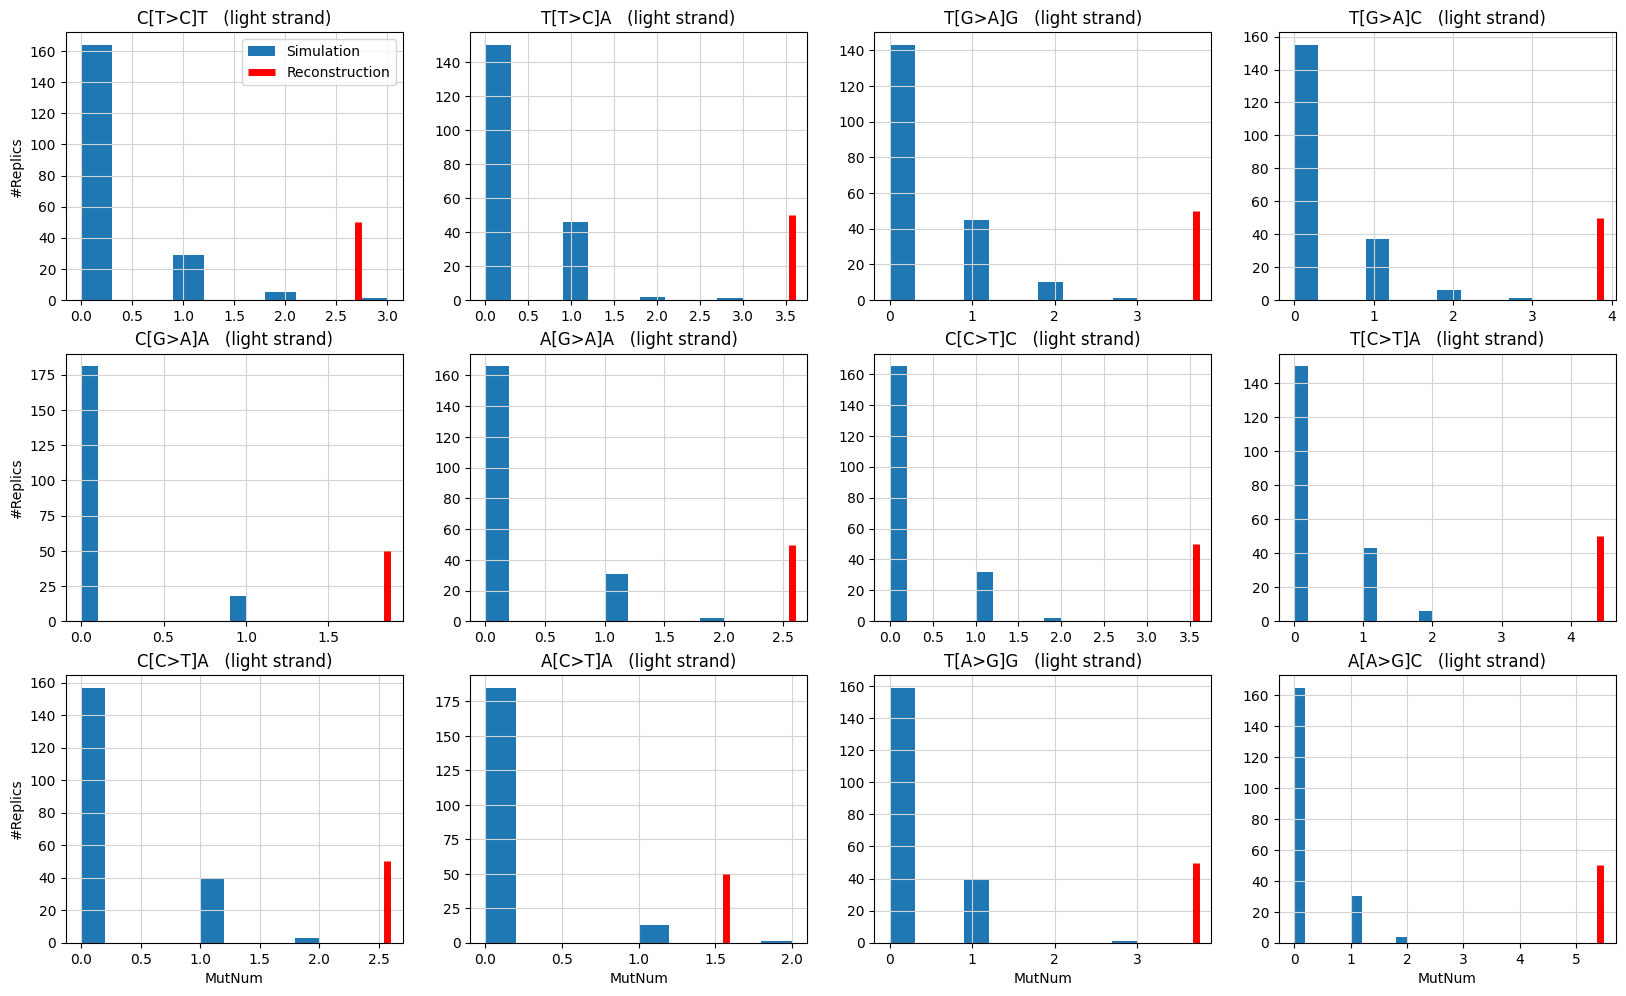

In [175]:
for lbl, data in zip(['human_cytb', 'human_nd1'], [human_cytb, human_nd1]):
    plt.figure(figsize=(20, 16))
    smuts = [x for x in possible_sbs192 if x in data["muts_positive"]]
    for i, sbs in enumerate(smuts, 1):
        sbs_distro = data["ms_exp192"][data["ms_exp192"].Mut == sbs]
        plt.subplot(4, 4, i)
        plt.grid(color="lightgray")
        sbs_distro.ObsNum.hist(label="Simulation")
        plt.vlines([data["ms_obs192"][data["ms_obs192"].Mut == sbs].ObsNum.item()], 0, 50, "r", linewidth=5, label="Reconstruction")
        plt.title(f"{rev_comp(sbs)}   (light strand)")
        if i > len(smuts) - 4:
            plt.xlabel("MutNum")
        if i % 4 == 1:
            plt.ylabel("#Replics")
        if i == 1:
            plt.legend()
    plt.savefig(f"../figures/{lbl}_sbs_significant.png", dpi=300, bbox_inches='tight')
    plt.show()

In [44]:
# save files for ET
# human_cytb["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/human_cytb_simulated_spectra.csv", index=False)
# human_nd1["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/human_nd1_simulated_spectra.csv", index=False)
# mus_cytb["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/mouse_cytb_simulated_spectra.csv", index=False)
# mus_nd1["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/mouse_nd1_simulated_spectra.csv", index=False)

# human_cytb["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/human_cytb_stats.csv")
# human_nd1["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/human_nd1_stats.csv")
# mus_cytb["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/mouse_cytb_stats.csv")
# mus_nd1["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/mouse_nd1_stats.csv")

In [117]:
for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    print(lbl)
    print("muts_positive:", list(data["muts_positive"]))
    print("muts_negative:", list(data["muts_negative"]))
    print()

human_cytb
muts_positive: ['A[A>G]G', 'A[A>G]T', 'A[G>A]G', 'A[T>C]C', 'C[G>A]T', 'G[A>G]A', 'G[C>T]C', 'G[G>A]A', 'G[T>C]T', 'T[A>G]G', 'T[A>G]T', 'T[C>T]C', 'T[G>A]G', 'T[T>C]C']
muts_negative: []

human_nd1
muts_positive: ['A[A>G]G', 'C[C>T]A', 'C[T>C]A', 'G[C>T]A', 'G[G>A]G', 'G[T>C]T', 'T[A>G]A', 'T[C>T]G', 'T[C>T]T', 'T[G>A]A', 'T[G>A]G', 'T[G>A]T']
muts_negative: []

mus_cytb
muts_positive: ['G[A>G]T', 'G[A>G]G', 'A[C>T]A']
muts_negative: ['C[T>A]T', 'C[T>A]G', 'G[G>T]G', 'T[C>A]G', 'C[T>C]C', 'C[A>C]C', 'G[C>T]A']

mus_nd1
muts_positive: ['T[A>G]T']
muts_negative: ['C[T>A]T', 'C[G>A]T', 'C[C>A]T', 'C[A>T]T', 'C[T>C]G', 'C[T>A]A', 'C[C>A]A', 'G[A>T]A', 'T[A>G]A']



In [81]:
fout = open("../data/exposure/consensus_labels_fr.txt", "w")
for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    fout.write(">"+lbl+"\n")
    fout.write(data['consensus']+"\n")
    muts_plus = data["mutations"][data["mutations"].Mut.isin(data["muts_positive"])]
    muts_minus = data["mutations"][data["mutations"].Mut.isin(data["muts_negative"])]

    muts_plus_est = muts_plus.groupby(["Mut", "PosInGene"]).ProbaFull.sum()
    muts_minus_est = muts_minus.groupby(["Mut", "PosInGene"]).ProbaFull.sum()

    pos_plus  = set(muts_plus_est[muts_plus_est > 0.5].reset_index().PosInGene.values)
    pos_minus = set(muts_minus_est[muts_minus_est > 0.5].reset_index().PosInGene.values)

    for pos in range(1, len(data['consensus'])+1):
        if pos in pos_plus:
            fout.write("+")
        elif pos in pos_minus:
            fout.write("-")
        else:
            fout.write(" ")
    fout.write("\n\n")

fout.close()

In [82]:
fout = open("../data/exposure/consensus_labels_fr_syn.txt", "w")
for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    fout.write(">"+lbl+"\n")
    fout.write(data['consensus']+"\n")
    muts_plus = data["mutations"][data["mutations"].Mut.isin(data["muts_positive"])]
    muts_minus = data["mutations"][data["mutations"].Mut.isin(data["muts_negative"])]

    muts_plus_est = muts_plus[muts_plus.Label >= 1].groupby(["Mut", "PosInGene"]).ProbaFull.sum()
    muts_minus_est = muts_minus[muts_minus.Label >= 1].groupby(["Mut", "PosInGene"]).ProbaFull.sum()

    pos_plus  = set(muts_plus_est[muts_plus_est > 0.5].reset_index().PosInGene.values)
    pos_minus = set(muts_minus_est[muts_minus_est > 0.5].reset_index().PosInGene.values)

    for pos in range(1, len(data['consensus'])+1):
        if pos in pos_plus:
            fout.write("+")
        elif pos in pos_minus:
            fout.write("-")
        else:
            fout.write(" ")
    fout.write("\n\n")

fout.close()

In [5]:
human_nd1["ms_obs12"] = pd.read_csv("../data/exposure/human_nd1/ms/ms12syn_human_nd1.tsv", sep="\t")
human_nd1["ms_exp12"] = pd.read_csv("../data/exposure/human_nd1/pyvolve/out/ms12syn_human_nd1_simulated.tsv", sep="\t")

human_nd1["ms_obs192"] = pd.read_csv("../data/exposure/human_nd1/ms/ms192syn_human_nd1.tsv", sep="\t")
human_nd1["ms_exp192"] = pd.read_csv("../data/exposure/human_nd1/pyvolve/out/ms192syn_human_nd1_simulated.tsv", sep="\t")


In [3]:
from pymutspec.draw import plot_mutspec12, plot_mutspec192

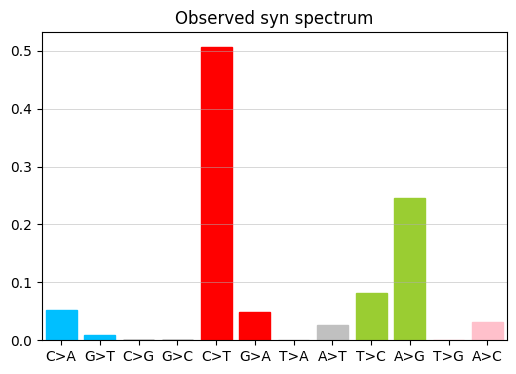

<AxesSubplot:title={'center':'Observed syn spectrum'}>

In [14]:
plot_mutspec12(human_nd1["ms_obs12"], title="Observed syn spectrum",)

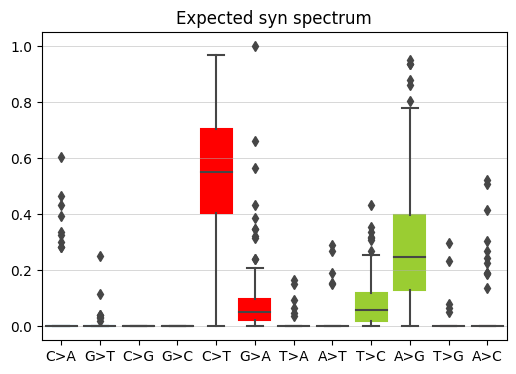

<AxesSubplot:title={'center':'Expected syn spectrum'}>

In [15]:
plot_mutspec12(human_nd1["ms_exp12"], title="Expected syn spectrum", style="box")

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


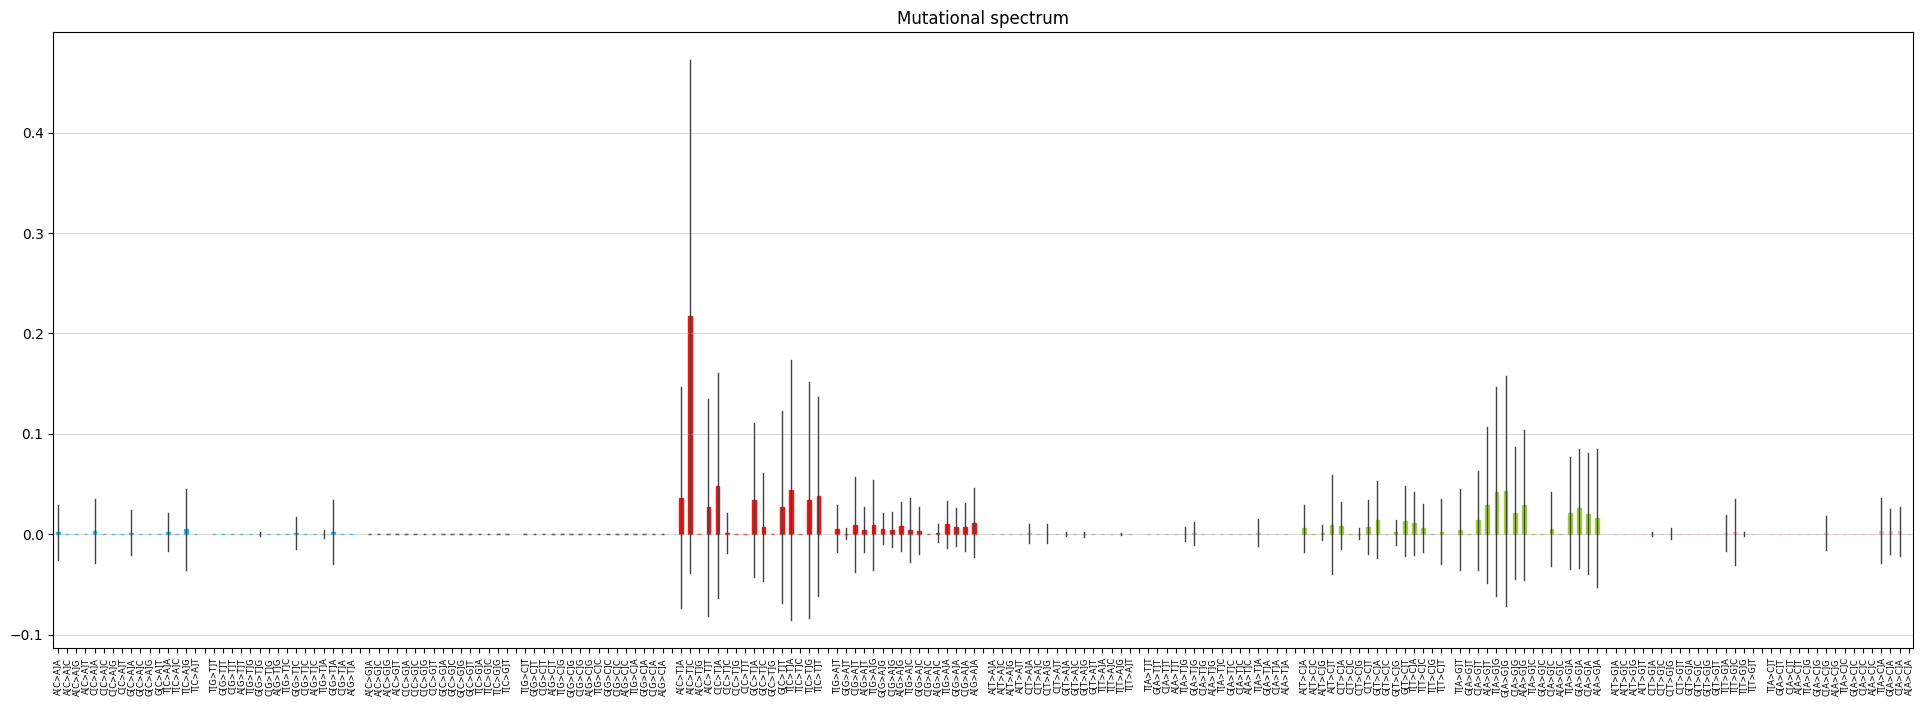

In [6]:
plot_mutspec192(human_nd1["ms_exp192"], ci="sd")

<AxesSubplot:xlabel='Mut', ylabel='MutSpec'>

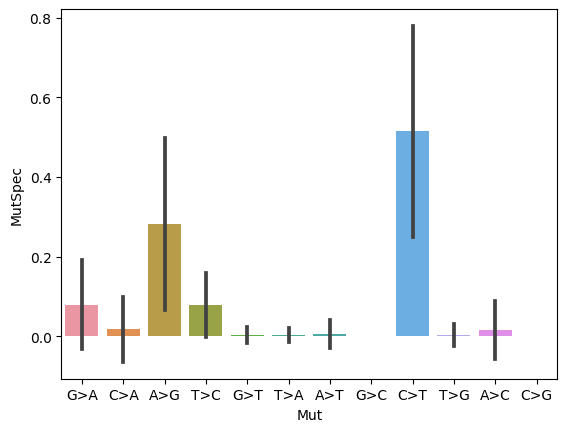

In [7]:
sns.barplot(data=human_nd1["ms_exp12"], x="Mut", y="MutSpec", ci='sd')